## Innoplexus Online Hiring Hackathon: Artificial Intelligence (AI) Challenge
#### Analytics Vidya

Classification of Web page content is vital to many tasks in Web information retrieval such as maintaining Web directories and focused crawling. The uncontrolled nature of Web content presents additional challenges to Web page classification as compared to traditional text classification, however the interconnected nature of hypertext also provides features that can assist the process.
The present task is to classify the web pages to the respective classes it belongs to, in a single label classification
setup (Each webpage can belong to only 1 class).
Basically given the complete html and url, predict the tag a web page belongs to out of 9 predefined tags as given
below:
1) People profile
2) Conferences/Congress
3) Forums
4) News article
5) Clinical trials
6) Publication
7) Thesis
8) Guidelines
9) Others

In [3]:
import pandas as pd
import numpy as np
import re, nltk        
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from bs4.element import Comment

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
import scipy.sparse as sparse
import string
import gc

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid")

In [4]:
#Reading the train data
train = pd.read_csv('train.csv')
html = pd.read_csv('html_data.csv')

In [30]:
training.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news


Let's build a quick dirty model by analyzing the url only.

In [23]:
#Using Porter Stemmer
stemmer = PorterStemmer()

#function to stem text tokens
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#function to tokenize text elements and removing numbers and punctuation
def tokenize(text):
    
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = text.split(" ")
    stems = stem_tokens(tokens, stemmer)
    return stems

# Tokenizing and vectorizing the text elements, eleminating stop words, using maximum of 1100 text tokens per document.
def vectorize(train, test):
    vectorizer = TfidfVectorizer(analyzer='word',tokenizer=tokenize,lowercase=True,stop_words ='english',max_features =1100)
    corpus_data_features = vectorizer.fit_transform(train['Url'].tolist() + test['Url'].tolist())

#Convering the document term matrix to numpy nd array
    corpus_data_features_nd = corpus_data_features.toarray()
    return corpus_data_features_nd

Split train data into training set and validation set based on Domain-Tag combination

In [28]:
def train_val_split(df):
    tags = df['Tag'].unique()
    val = []
    trn = []
    for tag in tags:
        df_tag = df[df['Tag']==tag]
        domains = df_tag['Domain'].unique()
        np.random.shuffle(domains)
        val.append(df_tag[df_tag['Domain'].isin(domains[2::3])])
        trn.append(df_tag[~df_tag['Domain'].isin(domains[2::3])])
    validation = pd.concat(val)
    training = pd.concat(trn)
    return training, validation

In [29]:
training, validation = train_val_split(train)

print(training.shape, validation.shape)

(36136, 4) (17311, 4)


In [61]:
features = vectorize(training, validation)
train_X = pd.DataFrame(features[0:len(training)])
train_y = training['Tag']
val_X = pd.DataFrame(features[len(training):])
val_y = validation['Tag']

In [62]:
tag_label = {'news':0, 
             'clinicalTrials':1, 
             'conferences':2, 
             'profile':3, 
             'forum':4, 
             'publication':5, 
             'thesis':6, 
             'guidelines':7,
             'others':8
            }
train_y = train_y.map(tag_label)
val_y = val_y.map(tag_label)

In [63]:
xg_train = xgb.DMatrix(train_X, label=train_y)
xg_test = xgb.DMatrix(val_X, label=val_y)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 9

In [64]:
#watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 5

bst = xgb.train(param, xg_train, num_round)
# get prediction
pred = bst.predict(xg_test)

In [66]:
f1_score(val_y, pred, average='weighted')  

0.6634919387393754

In [73]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 9,
    'nthread': 4}  # the number of classes that exist in this datset
num_round = 20 

bst = xgb.train(param, xg_train, num_round)
# get prediction
pred = bst.predict(xg_test)
f1_score(val_y, pred, average='weighted') 

0.66819681042924028

Using XGboost and tuning the parameter, the f1 score didnot improve significantly. With the information of url, the model performance is not very promising. We have to inlcude the HTML data.

### HTML parser

Extract the main web page content by recognizing the html tags.

In [7]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

Clean the web content text.

In [8]:
def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    text = u" ".join(t.strip() for t in visible_texts)
    text = text.replace(',','')
    return (re.sub(r'\s\s+',' ',text))

In [9]:
html['web_text'] = html['Html'].apply(lambda x: text_from_html(x))
del html['Html']

In [26]:
html.head()

,Webpage_id,web_text
0,1,Skip to main content Twitter LinkedIn Search ...
1,2,Skip to main content Twitter LinkedIn Search ...
2,3,Skip to main content Twitter LinkedIn Search ...
3,4,Skip to main content Twitter LinkedIn Search ...
4,5,Skip to main content Twitter LinkedIn Search ...


## Multiclass Classification Machine Learning

In [16]:
train['Tag'].value_counts()

others            17417
news               7992
publication        7705
profile            5196
conferences        4666
forum              4503
clinicalTrials     2839
thesis             1800
guidelines         1329
Name: Tag, dtype: int64

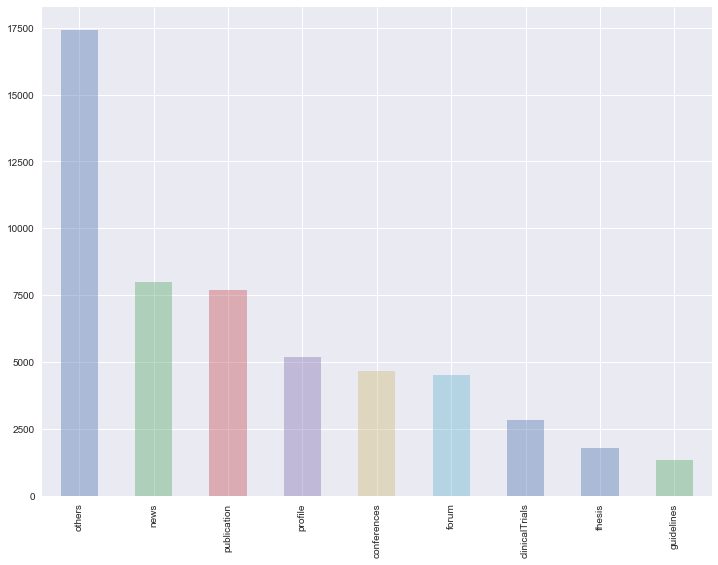

In [18]:
plt.figure(figsize=(12,9))
train['Tag'].value_counts().plot(kind='bar',alpha=0.4)

Clean train data url

In [5]:
train['url_clean'] = train.apply(lambda x: str(x['Url']).replace(x['Domain'],''),axis=1)

train['url_clean'] = train['url_clean'].apply(lambda x: (re.split('http:///|/|-',x))[1:])

Check if the length of url varies across different web page tags

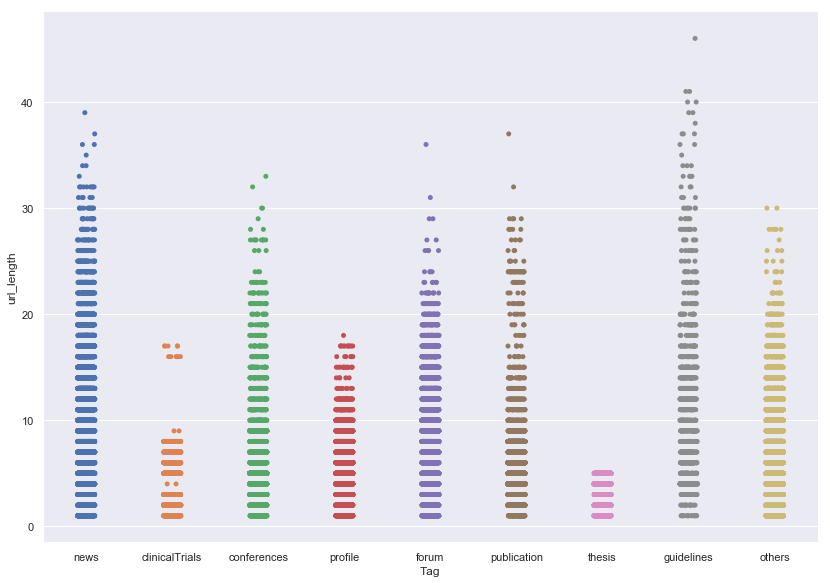

In [8]:
train['url_length'] = train['url_clean'].apply(lambda x: len(x))
plt.figure(figsize=(12,9))
sns.catplot(x="Tag", y="url_length", data=train, height=8.27, aspect=11.7/8.27)

In [28]:
train['url_text'] = train['url_clean'].apply(lambda x: ' '.join(x))
del train['Url']
del train['url_clean']

Join html data and train url data on Webpage_id.

In [29]:
html['Webpage_id'] = html['Webpage_id'].astype(int)

train = train.merge(html,on = 'Webpage_id',how='left')

In [30]:
train.isnull().sum()

Webpage_id    0
Domain        0
Tag           0
url_length    0
url_text      0
web_text      0
dtype: int64

In [13]:
train = train.dropna()

In [11]:
train.head()

,Webpage_id,Domain,Tag,url_length,url_text,web_text
0,1,www.fiercepharma.com,news,17.0,marketing tecfidera gilenya and aubagio s 3 wa...,Skip to main content Twitter LinkedIn Search ...
1,2,www.fiercepharma.com,news,12.0,pharma novo equipped to weather storm u s diab...,Skip to main content Twitter LinkedIn Search ...
2,3,www.fiercepharma.com,news,13.0,pharma another exec departs troubled endo and ...,Skip to main content Twitter LinkedIn Search ...
3,4,www.fiercepharma.com,news,11.0,pharma teva buy biosim specialist celltrion it...,Skip to main content Twitter LinkedIn Search ...
4,5,www.fiercepharma.com,news,12.0,marketing actress marissa tomei partners aller...,Skip to main content Twitter LinkedIn Search ...


In [14]:
vect_word = TfidfVectorizer(max_features=1000, analyzer='word', stop_words='english', ngram_range=(1,2), dtype=np.float32) 

tr_vect = vect_word.fit_transform(train['url_text'])

In [15]:
vect_web = TfidfVectorizer(max_features=5000, analyzer='word', stop_words='english', ngram_range=(1,2), dtype=np.float32) 

tr_vect_web = vect_web.fit_transform(train['web_text']) 

Encode the predicted class 'tag' into label for predictive modeling.

In [16]:
le = preprocessing.LabelEncoder()
le.fit(train['Tag'].astype(str))
train['Tag'] = le.transform(train['Tag'].astype(str))

The features included in the model is url_text, web_text and url_length.

In [17]:
Y = train['Tag']
train = train[['url_length']]
std = RobustScaler()
train = pd.DataFrame(std.fit_transform(train)).set_index(train.index)

train_features = hstack([tr_vect,tr_vect_web, csr_matrix(train.loc[train.index,])], 'csr')


Model 1: XGBClassifier

In [18]:
model1 = XGBClassifier()

model1.fit(train_features,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
y_pred_train_xgb = model1.predict(train_features)

In [25]:
accuracy = accuracy_score(Y, y_pred_train_xgb)
f1s = f1_score(Y, y_pred_train_xgb, average='weighted')  
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 score: %.2f" % (f1s))

Accuracy: 94.67%
F1 score: 0.95


Model 2: Logistic Regression

In [26]:
model2 = LogisticRegression()
model2.fit(train_features,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
y_pred_train_log = model2.predict(train_features)

In [29]:
accuracy = accuracy_score(Y, y_pred_train_log)
f2s = f1_score(Y, y_pred_train_log, average='weighted')  
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 score: %.2f" % (f2s))

Accuracy: 96.50%
F1 score: 0.96


### Model stacking
Stacking (also called meta ensembling) is a model ensembling technique used to combine information from multiple predictive models to generate a new model. Often times the stacked model (also called 2nd-level model) will outperform each of the individual models due to its smoothing nature and ability to highlight each base model.

In [30]:
stack = pd.DataFrame({'xgb':y_pred_train_xgb,'log':y_pred_train_log,'y':Y})
x_stack = stack[['xgb','log']]
Y_stack = stack['y']

In [31]:
stack_features = hstack([train_features, csr_matrix(x_stack.loc[x_stack.index,])], 'csr')

In [32]:
model3 = LogisticRegression()
model3.fit(stack_features,Y_stack)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
y_pred_train_stack = model3.predict(stack_features)
accuracy = accuracy_score(Y, y_pred_train_stack)
f3s = f1_score(Y, y_pred_train_stack, average='weighted')  
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 score: %.2f" % (f3s))

Accuracy: 96.72%
F1 score: 0.97


The F1 score improved significantly from 0.66 to 0.97 with analysis of the html web content and use of stacking method.